# Example of running pysm. 
There are two main modules to import when using PySM, `pysm` and `models`:

In [1]:
import pysm
from pysm.nominal import models

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

## Sky

`Sky` configuration dictionary. The keys specify which
components will be present; the items are lists
containing configuration dictionaries for each population of a component. 
Here we use some of the predefined models provided with `PySM` which can be accessed from the `models` module. 


In [2]:
nside = 64
sky_config = {
    'synchrotron' : models("s1", nside),
    'dust' : models("d1", nside),
    'freefree' : models("f1", nside),
    'cmb' : models("c1", nside),
    'ame' : models("a1", nside),
}

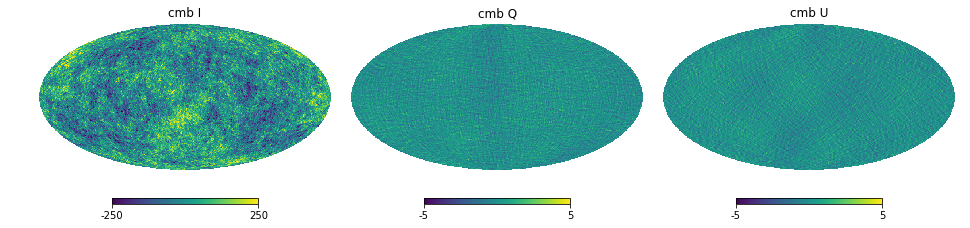

In [3]:
# initialise Sky 
sky = pysm.Sky(sky_config)

# Sky then has attributes corresponding to each of the sky
# components which return that component for a given frequency:
cmb = sky.cmb(nu = 23.)

fig = plt.figure(figsize = (13, 8))
hp.mollview(cmb[0], min = -250, max = 250, title = 'cmb I', sub = (131))
hp.mollview(cmb[1], min = -5, max = 5, title = 'cmb Q', sub = (132))
hp.mollview(cmb[2], min = -5, max = 5, title = 'cmb U', sub = (133))
plt.show()

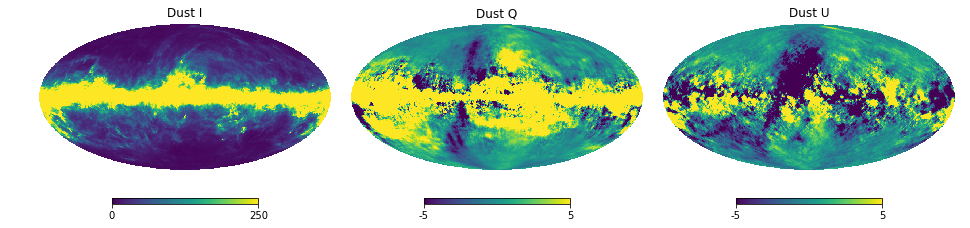

In [4]:
dust = sky.dust(300.)
fig = plt.figure(figsize = (13, 8))
hp.mollview(dust[0], min = 0, max = 250, title = 'Dust I', sub = (131))
hp.mollview(dust[1], min = -5, max = 5, title = 'Dust Q', sub = (132))
hp.mollview(dust[2], min = -5, max = 5, title = 'Dust U', sub = (133))
plt.show()

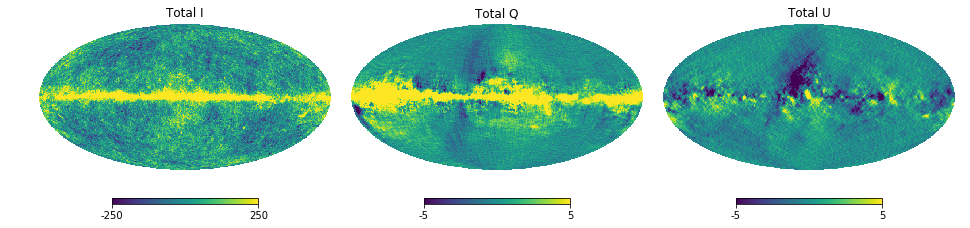

In [5]:
# or the total signal as a function of frequency:
total = sky.signal()(100.)
fig = plt.figure(figsize = (13, 8))
hp.mollview(total[0], min = -250, max = 250, title = 'Total I', sub = (131))
hp.mollview(total[1], min = -5, max = 5, title = 'Total Q', sub = (132))
hp.mollview(total[2], min = -5, max = 5, title = 'Total U', sub = (133))
plt.show()

We can also evaluate the signal for a vector of frequencies:

In [6]:
freqs = np.logspace(np.log10(30), np.log10(300), 30)
output = sky.signal()(freqs)
print("Shape of output is (N_freqs, 3, Npix): ", output.shape)

('Shape of output is (N_freqs, 3, Npix): ', (30, 3, 49152))


In [7]:
total_fgnd = np.std(output - sky.cmb(freqs), axis = 2)
dust = np.std(sky.dust(freqs), axis = 2)
synchrotron = np.std(sky.synchrotron(freqs), axis = 2)
freefree = np.std(sky.freefree(freqs), axis = 2)
ame = np.std(sky.ame(freqs), axis = 2)
cmb = np.std(sky.cmb(freqs), axis = 2)

(10, 1000)

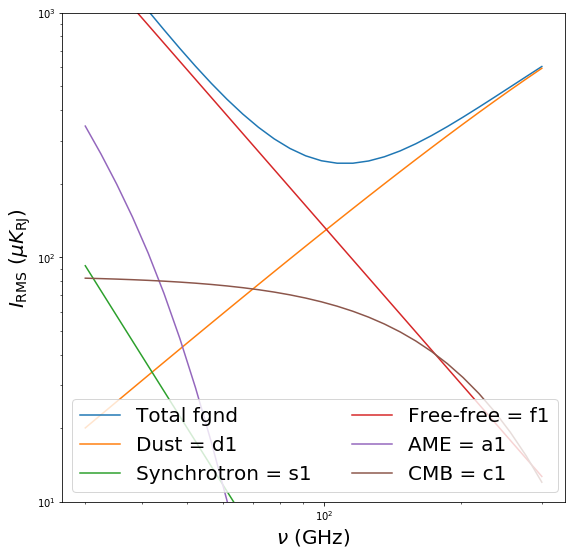

In [8]:
plt.figure(figsize = (9, 9))
plt.loglog(freqs, total_fgnd[:, 0], label = "Total fgnd")
plt.loglog(freqs, dust[:, 0], label = "Dust = d1")
plt.loglog(freqs, synchrotron[:, 0], label = "Synchrotron = s1")
plt.loglog(freqs, freefree[:, 0], label = "Free-free = f1")
plt.loglog(freqs, ame[:, 0], label = "AME = a1")
plt.loglog(freqs, cmb[:, 0], label = "CMB = c1")
plt.legend(fontsize = 20, ncol = 2)
plt.xlabel(r"$\nu$ (GHz)", fontsize = 20)
plt.ylabel(r"$I_{\rm RMS}$ ($\mu K_{\rm RJ}$)", fontsize = 20)
plt.ylim([10, 1000])

## Instrument

If we want to add instrument effects then use the `Instrument` class. Since this isn't easily a function of frequency it writes maps to file for a given set of observation frequencies, noise, bandpass etc.

Instantiating the `Instrument` object requires a configuration dictionary, as in the case of `Sky`. 

### Delta Bandpasses

First we will consider the case of delta bandpasses, and so we use the `frequencies` key to specify the observation frequencies. 



In [9]:
instrument_delta_bpass = {
    'frequencies' : np.logspace(1., 3., 20),
    'beams' : np.ones(20)*70.,
    'sens_I' : np.ones(20),
    'sens_P' : np.ones(20),
    'nside' : nside,
    'noise_seed' : 1234,
    'use_bandpass' : False,
    'add_noise' : True,
    'output_units' : 'uK_RJ',
    'use_smoothing' : True,
    'output_directory' : './',
    'output_prefix' : 'test',
}

instrument = pysm.Instrument(instrument_delta_bpass)
instrument.observe(sky)

nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0010.00 | 01.00 | 01.00 | 70.00 
0012.74 | 01.00 | 01.00 | 70.00 
0016.24 | 01.00 | 01.00 | 70.00 
0020.69 | 01.00 | 01.00 | 70.00 
0026.37 | 01.00 | 01.00 | 70.00 
0033.60 | 01.00 | 01.00 | 70.00 
0042.81 | 01.00 | 01.00 | 70.00 
0054.56 | 01.00 | 01.00 | 70.00 
0069.52 | 01.00 | 01.00 | 70.00 
0088.59 | 01.00 | 01.00 | 70.00 
0112.88 | 01.00 | 01.00 | 70.00 
0143.84 | 01.00 | 01.00 | 70.00 
0183.30 | 01.00 | 01.00 | 70.00 
0233.57 | 01.00 | 01.00 | 70.00 
0297.64 | 01.00 | 01.00 | 70.00 
0379.27 | 01.00 | 01.00 | 70.00 
0483.29 | 01.00 | 01.00 | 70.00 
0615.85 | 01.00 | 01.00 | 70.00 
0784.76 | 01.00 | 01.00 | 70.00 
1000.00 | 01.00 | 01.00 | 70.00 


### Arbitrary Bandpasses

Next we consider tophat bandpasses, which we give as a list of tuples: `[(frequencies_1, weights_1), (frequencies_2, weights_2) ... ]` to the `channel` key. We must also provide names of these channels as a list of strings to the `channel_names` key. In this case we do not need to set `frequencies` since all outputs are defined by the bandpasses.

In [10]:
instrument_bpass = {
    'use_smoothing' : True,
    'beams' : np.array([30., 40., 50.]), # beam fwhm in arcmin
    'nside' : nside,
    'add_noise' : True,
    'sens_P' : np.array([4.5, 4.2, 3.1]), # channel sensitivities in uK_CMB amin
    'sens_I' : np.array([3.5, 3.2, 2.1]),
    'use_bandpass' : True,
    'channels' : [(np.linspace(20, 25, 10), np.ones(10)), (np.linspace(30, 35, 10), np.ones(10)), (np.linspace(40, 45, 10), np.ones(10))],
    'channel_names' : ['channel_1', 'channel_2', 'channel_3'],
    'output_units' : 'uK_RJ',
    'output_directory' : './',
    'output_prefix' : 'test',
}

instrument = pysm.Instrument(instrument_bpass)
instrument.observe(sky)

Channel name | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) |
channel_1 | 03.50 | 04.50 | 30.00 
channel_2 | 03.20 | 04.20 | 40.00 
channel_3 | 02.10 | 03.10 | 50.00 


## Altering Models

If you would like to change the parameters of any of the provided models in PySM then all you need to do is change the component configuration dictionaries. For example let's look at altering one of the dust models, d2. d2 is a single-component dust model, and so d2 is a list with one dictionary in it:

In [11]:
d2 = models("d2", nside)
print d2[0]

{'nu_0_P': 353.0, 'A_U': array([-0.37160524,  0.14281762, -0.28398006, ..., -0.33329034,
        0.42752389,  0.1651527 ]), 'temp': array([ 23.08866739,  23.69089377,  23.57512546, ...,  24.50929832,
        23.70203817,  23.98123991]), 'A_Q': array([ 0.10248631, -0.06640576,  0.06705124, ...,  0.29683848,
       -0.22423878,  0.08623339]), 'spectral_index': array([ 1.52334543,  1.94271184,  1.77362656, ...,  1.51095494,
        1.32299377,  1.40287277]), 'nu_0_I': 545.0, 'model': 'modified_black_body', 'add_decorrelation': False, 'A_I': array([ 10.12556483,  10.94025714,  12.40703967, ...,  10.10966552,
        13.93021944,  14.63677579])}


We can see the templates used:

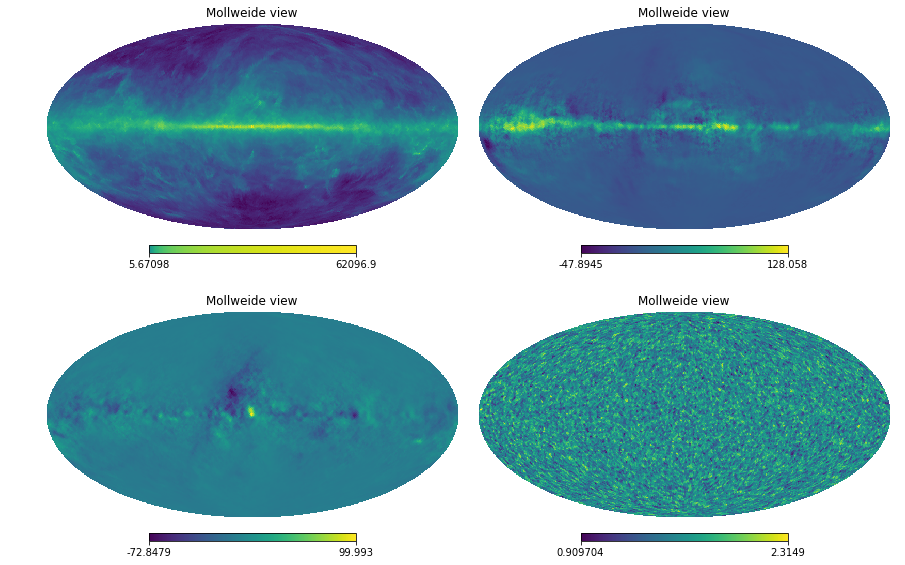

In [12]:
fig = plt.figure(figsize = (12, 8))
hp.mollview(d2[0]['A_I'], norm = 'log', sub = (221))
hp.mollview(d2[0]['A_Q'], sub = (222))
hp.mollview(d2[0]['A_U'], sub = (223))
hp.mollview(d2[0]['spectral_index'], sub = (224))


We could change the spectral index to be constant across the sky:

In [13]:
d2[0]['spectral_index'] = 1.54

In [14]:
sky = pysm.Sky({'dust' : d2})

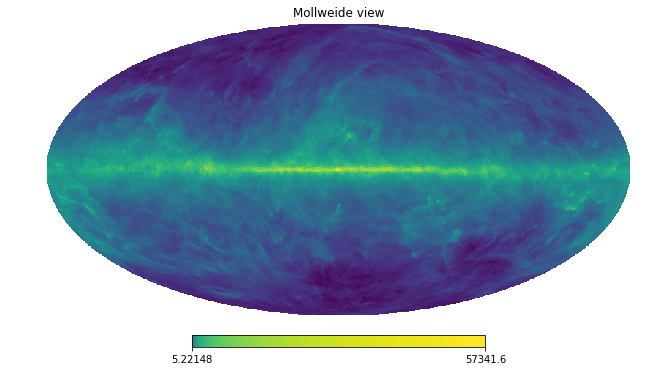

In [15]:
hp.mollview(sky.dust(500.)[0], norm = 'log')
